In [7]:
%load_ext autoreload
%autoreload 2
import sklearn
from sklearn.datasets import load_wine, load_iris
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt

from isometry_pursuit.experiment import run_resampling_experiment
from isometry_pursuit.plot import box_plot
from isometry_pursuit.transformation import exponential_transformation
from isometry_pursuit.algorithm import greedy, brute, group_basis_pursuit
from isometry_pursuit.loss import isometry_loss, group_lasso_norm


import random

np.random.seed(1234)
random.seed(1234)

In [8]:
# # Simulation setup
# np.random.seed(42)
# D = 2  # Dimension constraint for selection
# n_features = 4
# power = 1

# # Generate a random design matrix X
# theta1 = 5*np.pi / 6
# theta2 = np.pi/4
# theta3 = 7*np.pi/4
# X = np.asarray([[1,0],
#                 [np.cos(theta1),np.sin(theta1)],
#                 [np.cos(theta2), np.sin(theta2)],
#                 [np.cos(theta3), np.sin(theta3)]]).transpose()
# X = np.hstack([np.hstack([X[:,:2]]*1), X[:,2:]])

# # Greedy algorithm
# for i in range(10):
#     output_indices = greedy(X, lambda x: isometry_loss(x, power), random_state=i)
#     greedy_loss = isometry_loss(X[:, output_indices], power)
#     print(greedy_loss)

In [9]:
# beta = group_basis_pursuit(X)

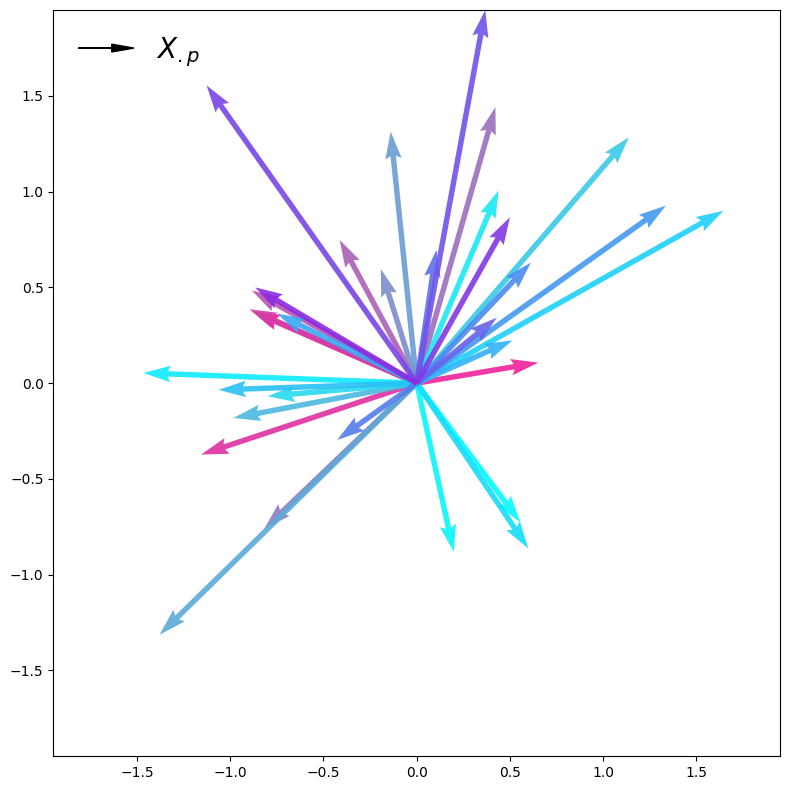

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(2)
# Set the number of vectors
num_vectors = 30

# All vectors start at the origin
start_x = np.zeros(num_vectors)
start_y = np.zeros(num_vectors)

# Generate random directions and magnitudes for the vectors
angles = np.random.uniform(0, 2 * np.pi, num_vectors)  # Random angles
# magnitudes = np.random.normal(0.5, 1.5, num_vectors)    # Random lengths
magnitudes = np.exp(np.random.uniform(np.log(0.5), np.log(2), num_vectors))

end_x = magnitudes * np.cos(angles)                    # X components
end_y = magnitudes * np.sin(angles)                    # Y components

# Xs = exponential_transformation(np.asarray([end_x, end_y]))
# end_x = Xs[0]
# end_y = Xs[1]

# Add two vectors at right angles to each other
theta = np.pi / 3
end_x = np.append(end_x, [np.cos(theta), np.cos(theta + np.pi/2)])  # One along the x-axis
end_y = np.append(end_y, [np.sin(theta), np.sin(theta + np.pi/2)])  # One along the y-axis
start_x = np.append(start_x, [0, 0])
start_y = np.append(start_y, [0, 0])

xlim = max([np.abs(end_x.min()), end_x.max(), np.abs(end_y.min()), end_y.max()])
ylim = xlim


# Define a bright Miami-inspired color gradient
miami_cmap = LinearSegmentedColormap.from_list("MiamiPalette", ["#FF1493", "#00FFFF", "#8A2BE2"])  # Hot pink, cyan, deep purple
colors = miami_cmap(np.linspace(0, 1, len(end_x)))  # Generate colors based on the number of vectors

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot each vector
for i in range(len(end_x)):
    plt.quiver(
        start_x[i], start_y[i],      # Starting point (all at origin)
        end_x[i], end_y[i],          # Vector direction
        angles='xy', scale_units='xy', scale=1, # Keep vectors at correct scale
        color=colors[i],             # Use continuous Miami-inspired colors
        alpha=0.9                    # Make colors pop
    )

    from matplotlib.lines import Line2D

# colorful_title(ax, "Interpretable features", colors)

# Set axis limits and remove gridlines
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
# Add a custom arrow in the legend
# Adding an arrow
# Create a horizontal arrow legend entry
# Create a dummy arrow for the legend
arrow_for_legend = mpatches.FancyArrow(0, 0, 1, 0, color='black')
from matplotlib.patches import FancyArrow
# Add the legend with the custom handler
plt.legend(handles=[arrow_for_legend], labels=[r"$X_{.p}$"], fontsize = 20, frameon = False, handler_map={mpatches.FancyArrow: HandlerArrow()}, loc="upper left")

# S
# Display the plot
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/isometry-pursuit/figures/data.png')


In [11]:
from matplotlib.legend_handler import HandlerPatch

# Custom legend handler for the arrow
class HandlerArrow(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        arrow = FancyArrow(0, 0.5*height, width, 0, 
                           length_includes_head=True, 
                           head_width=0.4*height, 
                           head_length=0.4*width, 
                           color=orig_handle.get_edgecolor(), 
                           linewidth=orig_handle.get_linewidth())
        arrow.set_transform(trans)
        return [arrow]


In [12]:
# Custom legend handler for a dotted circle
class HandlerDottedCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create a small circle with a dotted edge
        circle = Circle(
            (width / 2, height / 2),  # Center of the circle
            radius=height / 3,       # Radius of the circle
            edgecolor='black',       # Edge color
            facecolor='none',        # No fill
            linestyle=':',           # Dotted line style
            linewidth=1.5
        )
        circle.set_transform(trans)
        return [circle]


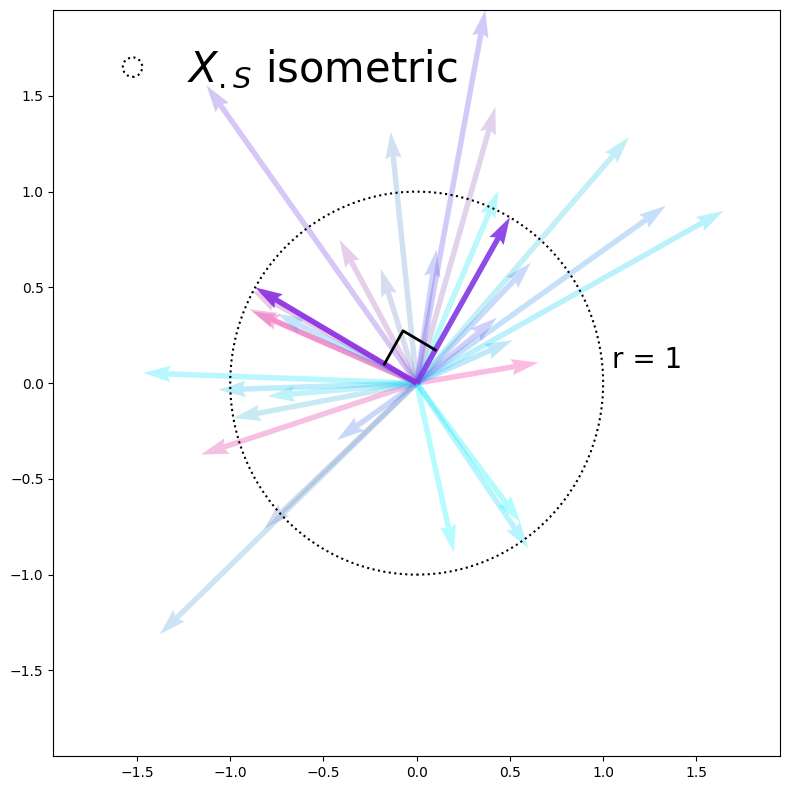

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(2)
# Set the number of vectors
num_vectors = 30

# All vectors start at the origin
start_x = np.zeros(num_vectors)
start_y = np.zeros(num_vectors)

# Generate random directions and magnitudes for the vectors
angles = np.random.uniform(0, 2 * np.pi, num_vectors)  # Random angles
magnitudes = np.exp(np.random.uniform(np.log(0.5), np.log(2), num_vectors))

end_x = magnitudes * np.cos(angles)                    # X components
end_y = magnitudes * np.sin(angles)                    # Y components

# Add two vectors at right angles to each other
theta = np.pi / 3
x1, y1 = np.cos(theta), np.sin(theta)
x2, y2 = -y1, x1  # Perpendicular vector

end_x = np.append(end_x, [x1, x2])
end_y = np.append(end_y, [y1, y2])
start_x = np.append(start_x, [0, 0])
start_y = np.append(start_y, [0, 0])

xlim = max([np.abs(end_x.min()), end_x.max(), np.abs(end_y.min()), end_y.max()])
ylim = xlim

# Define a bright Miami-inspired color gradient
miami_cmap = LinearSegmentedColormap.from_list("MiamiPalette", ["#FF1493", "#00FFFF", "#8A2BE2"])  # Hot pink, cyan, deep purple
# colors = miami_cmap(np.linspace(0, 1, len(end_x) - 2))  # Generate colors for random vectors
# colors = np.vstack([colors, [[1, 0, 0, 1], [0, 0, 1, 1]]])  # Add red and blue for the right-angle vectors
colors = miami_cmap(np.linspace(0, 1, len(end_x)))  # Generate colors based on the number of vectors

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot random vectors with faint colors
for i in range(num_vectors):
    plt.quiver(
        start_x[i], start_y[i],      # Starting point (all at origin)
        end_x[i], end_y[i],          # Vector direction
        angles='xy', scale_units='xy', scale=1, # Keep vectors at correct scale
        color=[colors[i][0], colors[i][1], colors[i][2], 0.3],  # Make them faint
        alpha=0.3
    )

# Plot right-angle vectors with bold colors
for i in range(num_vectors, len(end_x)):
    plt.quiver(
        start_x[i], start_y[i],      # Starting point (all at origin)
        end_x[i], end_y[i],          # Vector direction
        angles='xy', scale_units='xy', scale=1, # Keep vectors at correct scale
        color=colors[i],             # Use prominent colors for right-angle vectors
        alpha=0.9
    )

# Add a right-angle symbol
symbol_scale = 0.2  # Scale for the right-angle symbol
corner_x = x1 * symbol_scale
corner_y = y1 * symbol_scale

symbol_x = [corner_x, corner_x + x2 * symbol_scale, x2 * symbol_scale]
symbol_y = [corner_y, corner_y + y2 * symbol_scale, y2 * symbol_scale]

plt.plot(symbol_x, symbol_y, color='black', linewidth=2)

# Add a dotted black circle with radius 1
circle = plt.Circle((0, 0), 1, color='black', linestyle='dotted', fill=False, linewidth=1.5)
ax.add_artist(circle)

# Add a small line and label "r = 1" on the x-axis
# ax.plot([1, 1], [0, 0.05], color='black', linewidth=1.5)  # Small vertical line at x=1
ax.text(1.05, 0.05, "r = 1", fontsize=20, color='black', ha='left', va='bottom')  # Label



# Set axis limits
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
# Create a dummy dotted circle for the legend
from matplotlib.patches import Circle
dotted_circle = Circle((0, 0), radius=1.2, edgecolor='black', facecolor='none')

# Add the legend with the custom handler
plt.legend(handles=[dotted_circle], fontsize = 30,frameon = False,labels=[r"$X_{.S}$ isometric"], handler_map={Circle: HandlerDottedCircle()}, loc="upper left",    handletextpad=0.3,  # Adjusts the space between the symbol and text
    labelspacing=0.,   # Adjusts vertical space between legend entries
)

# Display the plot
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/isometry-pursuit/figures/selection.png')


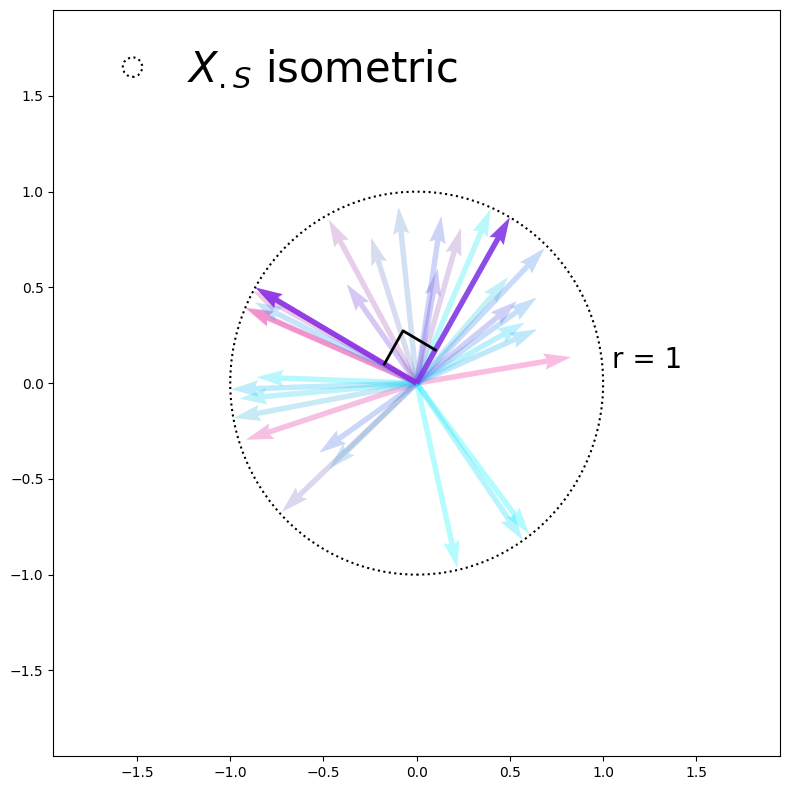

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(2)
# Set the number of vectors
num_vectors = 30

# All vectors start at the origin
start_x = np.zeros(num_vectors)
start_y = np.zeros(num_vectors)

# Generate random directions and magnitudes for the vectors
angles = np.random.uniform(0, 2 * np.pi, num_vectors)  # Random angles
magnitudes = np.exp(np.random.uniform(np.log(0.5), np.log(2), num_vectors))

end_x = magnitudes * np.cos(angles)                    # X components
end_y = magnitudes * np.sin(angles)                    # Y components

Xs = exponential_transformation(np.asarray([end_x, end_y]))
end_x = Xs[0]
end_y = Xs[1]


# Add two vectors at right angles to each other
theta = np.pi / 3
x1, y1 = np.cos(theta), np.sin(theta)
x2, y2 = -y1, x1  # Perpendicular vector

end_x = np.append(end_x, [x1, x2])
end_y = np.append(end_y, [y1, y2])


start_x = np.append(start_x, [0, 0])
start_y = np.append(start_y, [0, 0])

# xlim = max([np.abs(end_x.min()), end_x.max(), np.abs(end_y.min()), end_y.max()])
# ylim = xlim

# Define a bright Miami-inspired color gradient
miami_cmap = LinearSegmentedColormap.from_list("MiamiPalette", ["#FF1493", "#00FFFF", "#8A2BE2"])  # Hot pink, cyan, deep purple
# colors = miami_cmap(np.linspace(0, 1, len(end_x) - 2))  # Generate colors for random vectors
# colors = np.vstack([colors, [[1, 0, 0, 1], [0, 0, 1, 1]]])  # Add red and blue for the right-angle vectors
colors = miami_cmap(np.linspace(0, 1, len(end_x)))  # Generate colors based on the number of vectors

# Create a figure
fig, ax = plt.subplots(figsize=(8, 8))






# Plot random vectors with faint colors
for i in range(num_vectors):
    plt.quiver(
        start_x[i], start_y[i],      # Starting point (all at origin)
        end_x[i], end_y[i],          # Vector direction
        angles='xy', scale_units='xy', scale=1, # Keep vectors at correct scale
        color=[colors[i][0], colors[i][1], colors[i][2], 0.3],  # Make them faint
        alpha=0.3
    )

# Plot right-angle vectors with bold colors
for i in range(num_vectors, len(end_x)):
    plt.quiver(
        start_x[i], start_y[i],      # Starting point (all at origin)
        end_x[i], end_y[i],          # Vector direction
        angles='xy', scale_units='xy', scale=1, # Keep vectors at correct scale
        color=colors[i],             # Use prominent colors for right-angle vectors
        alpha=0.9
    )

# Add a right-angle symbol
symbol_scale = 0.2  # Scale for the right-angle symbol
corner_x = x1 * symbol_scale
corner_y = y1 * symbol_scale

symbol_x = [corner_x, corner_x + x2 * symbol_scale, x2 * symbol_scale]
symbol_y = [corner_y, corner_y + y2 * symbol_scale, y2 * symbol_scale]

plt.plot(symbol_x, symbol_y, color='black', linewidth=2)

# Add a dotted black circle with radius 1
circle = plt.Circle((0, 0), 1, color='black', linestyle='dotted', fill=False, linewidth=1.5)
ax.add_artist(circle)

# Add a small line and label "r = 1" on the x-axis
# ax.plot([1, 1], [0, 0.05], color='black', linewidth=1.5)  # Small vertical line at x=1
ax.text(1.05, 0.05, "r = 1", fontsize=20, color='black', ha='left', va='bottom')  # Label



# Set axis limits
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
# Create a dummy dotted circle for the legend

dotted_circle = Circle((0, 0), radius=1.2, edgecolor='black', facecolor='none')

# Add the legend with the custom handler
plt.legend(handles=[dotted_circle], fontsize = 30,frameon = False,labels=[r"$X_{.S}$ isometric"], handler_map={Circle: HandlerDottedCircle()}, loc="upper left",    handletextpad=0.3,  # Adjusts the space between the symbol and text
    labelspacing=0.,   # Adjusts vertical space between legend entries
)

# Display the plot
plt.tight_layout()
plt.savefig('/Users/samsonkoelle/isometry-pursuit/figures/normalization.png')
